<h2>CS 4780/5780 Final Project: </h2>
<h3>COVID-19 Hospitalizations Prediction for EU Countries</h3>

Names and NetIDs for your group members:

Connor McCarthy (cjm365), Corban Chiu (cpc75), & Rucha Gharpure (rpg75)


<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is predicting hospitalizations due to COVID-19. Although hospitalizations are directly related to COVID-19 cases, the different populations, timelines and reactionary measures of different EU countries result in different trends in hospitalization numbers. In this project you will bring the power of machine learning to make predictions for the country-level hospitalizations using COVID-19 age group case data and also previous hospitalization data. There will be two tasks, one will be a basic problem that will require you to use methods learned in class. The second task will be more difficult and will require some additional intuition and insight. <b>Please read the project description PDF file carefully and follow the instructions there. Also make sure you write your code and answers to all the questions in this Jupyter Notebook </b> </p>
<p>


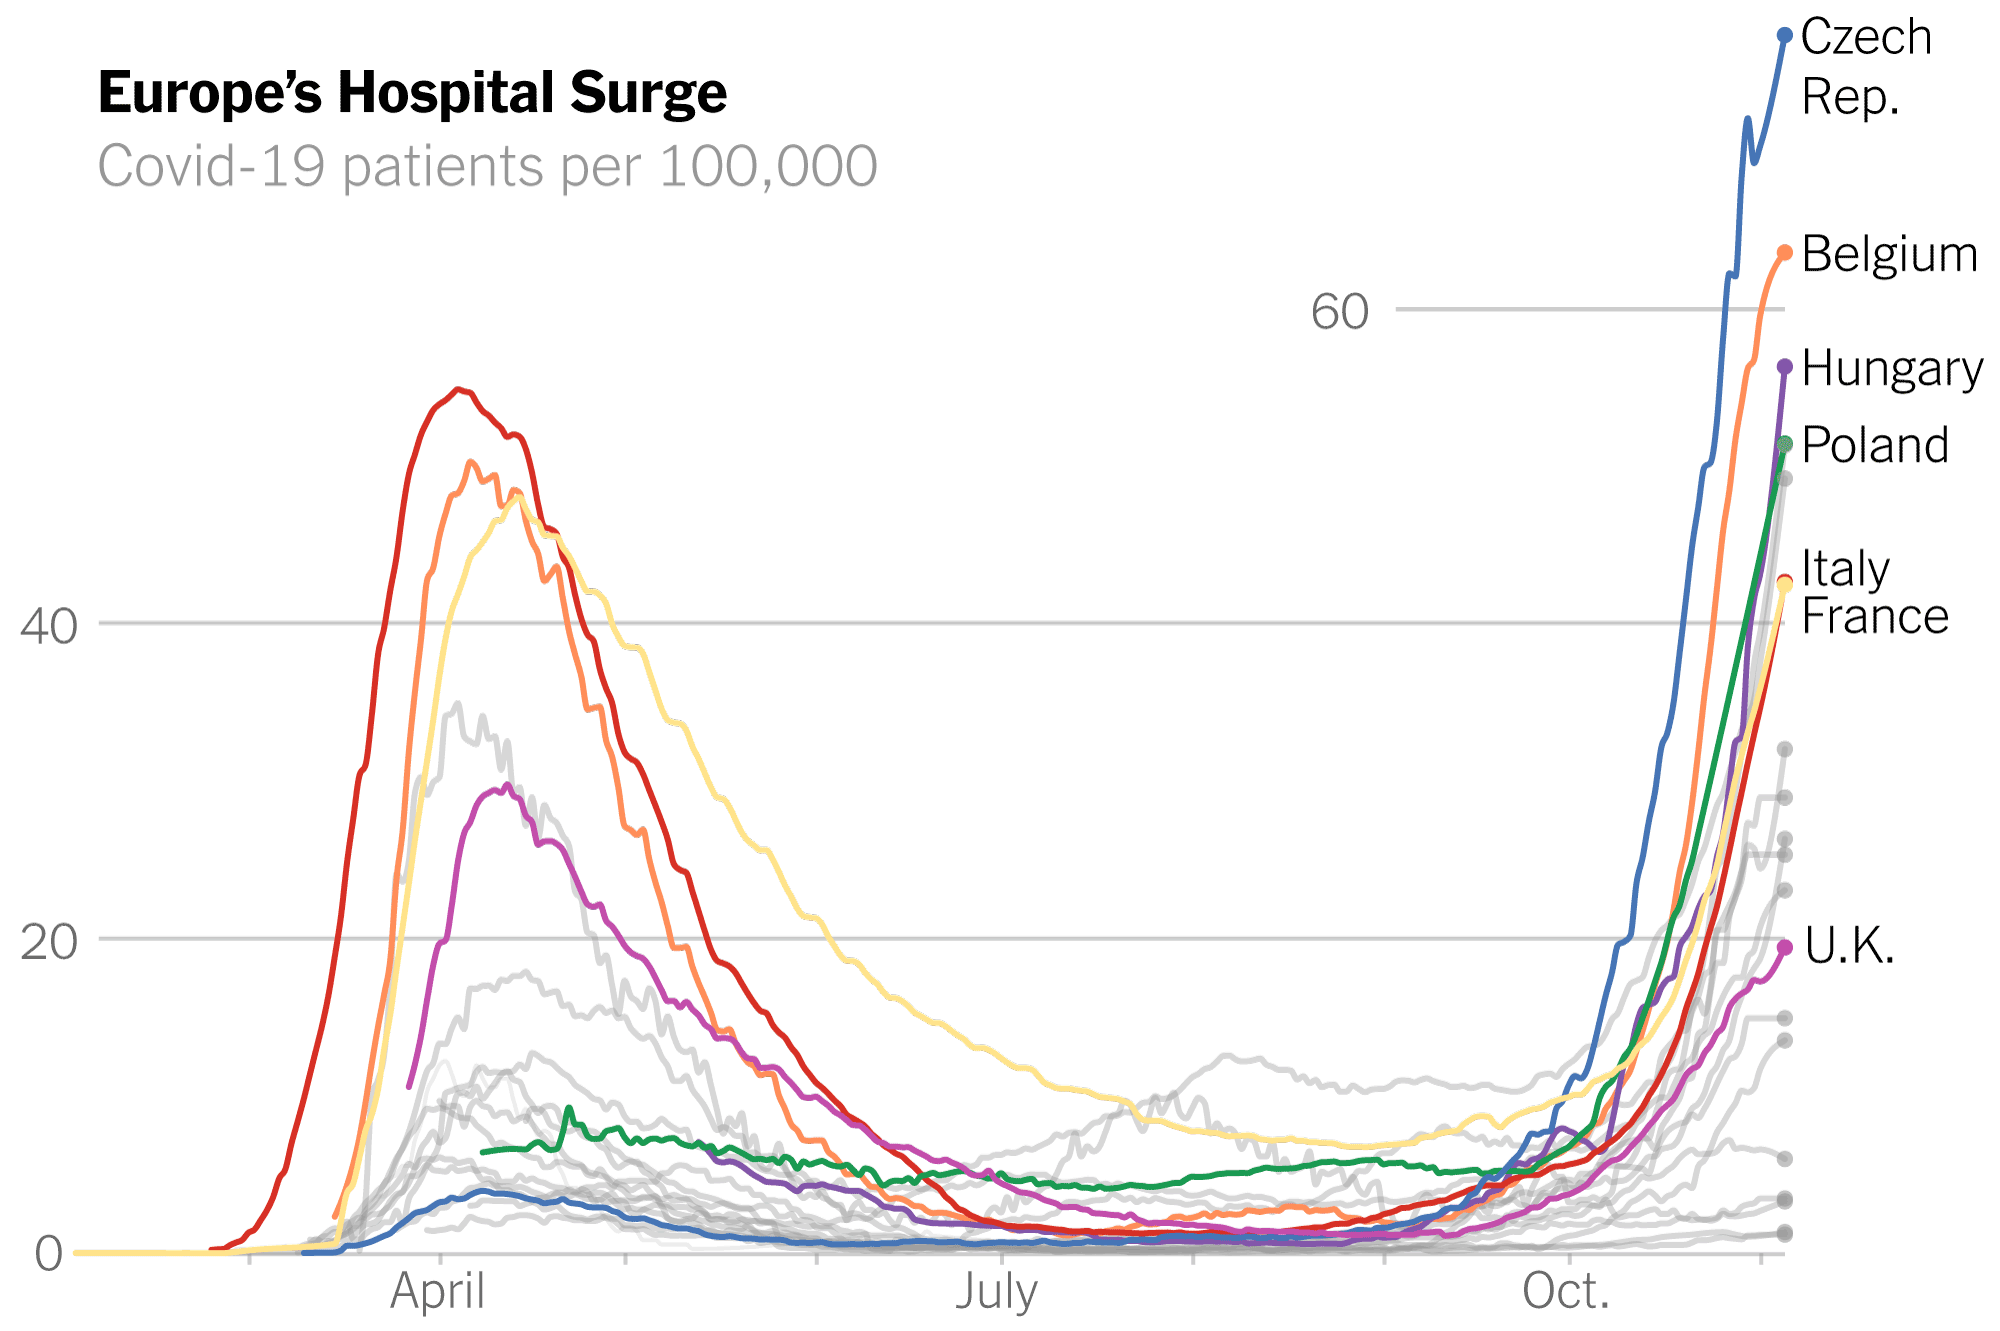

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [3]:
# Imports for the basic solution
import os
import pandas as pd
import numpy as np
import datetime
from sklearn import svm, tree 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(threshold=np.inf)

# Imports for the creative solution
from sklearn.neural_network import MLPRegressor
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# TODO

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<h3>1.2 Accuracy and Mean Squared Error:</h3><p>
To measure your performance in the Kaggle Competition, we are using accuracy and mean squared error (MSE). As a recap, accuracy is the percent of labels you predict correctly and MSE is the average squared difference between the estimated values and the actual value. To measure this, you can use library functions from sklearn. A simple example is shown below. 
<p>

In [4]:
from sklearn.metrics import accuracy_score
y_pred = [3, 2, 1, 0, 1, 2, 3]
y_true = [0, 1, 2, 3, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.42857142857142855

In [5]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_pred)

2.857142857142857

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). Think of what modifications can be done to the data to make it more easily interpretable.
<p>

In [6]:
# Reading the csv file to a pandas dataframe and then converting to numpy
Tr = pd.read_csv('datasets/train_baseline.csv', sep= ',', encoding='unicode_escape')
Tr = Tr.to_numpy()
# Shuffling the rows
np.random.shuffle(Tr)
# Not including the "under 15" column as a feature
xTr = np.append(Tr[:,:4],Tr[:,5:-1], axis = 1)
yTr = Tr[:,-1:]
# Importing test data
xTe = pd.read_csv('datasets/test_baseline_no_label.csv', sep= ',', encoding='unicode_escape').to_numpy()
xTe = np.append(xTe[:,:4],xTe[:,5:], axis = 1)

def process_countries(xTr):
    '''
    One-hot encoding for all of the countries
    '''
    countries = xTr[:,0]
    n, d = xTr.shape
    unique_countries = np.unique(countries)

    new_countries = np.zeros((n, len(np.unique(countries))))
    for idx,val in enumerate(countries):
        c_val = np.where(unique_countries==val)
        new_countries[idx, c_val] = 1
    return new_countries

def process_days(xTr):
    '''
    Creating features for days since 1/1/20, weeks since 1/1/20, and day of week
    '''
    n, d = xTr.shape
    date = xTr[:,1:3]
    date_features = np.zeros((n, 3))
    for idx, val in enumerate(date[:, 0]):

        date_object = datetime.datetime.strptime(val, '%m/%d/%Y').date()
        dow = datetime.datetime.weekday(date_object)
        #month = date_object.month
        date_features[idx, 0] = dow
        jan = datetime.date(2020, 1, 1)
        day_count = (date_object -jan).days
        #wk_count = np.floor(day_count/7)
        date_features[idx, 1] = day_count
        #date_features[idx, 2] = month
        #date_features[idx, 2] = wk_count
    
    for idx, val in enumerate(date[:, 1]):
        week_idx = val.index("W") + 1
        wk = int(val[week_idx:])
        date_features[idx, 2] = wk
    return date_features
    
def transform_features(xTr, xTe):
    '''
    Normalizes the COVID case data based on the total column
    '''
    tr_rest = xTr[:,3:]
    train_countries = process_countries(xTr)
    test_countries = process_countries(xTe)
    train_dates = process_days(xTr)
    test_dates = process_days(xTe)
    #normalization of other features
    tr_rest = np.concatenate((train_dates, tr_rest), axis = 1)
    m = np.mean(tr_rest, axis=0)
    s = np.std(tr_rest, axis=0, dtype=np.float64)
    tr_rest = (tr_rest - m) / s
    xTe_rest = np.concatenate((test_dates, xTe[:, 3:]), axis = 1)
    xTe_rest = (xTe_rest - m) / s
    tr_final = np.concatenate((train_countries, tr_rest), axis = 1)
    te_final = np.concatenate((test_countries, xTe_rest), axis = 1)
    
    
    return tr_final, te_final
    
# xTr_fit, xTe_fit are our new feature vectors
xTr_fit, xTe_fit = transform_features(xTr, xTe)

<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [7]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4

def svm_train(train, val, ytrain, yval):
    '''
    Trains an SVM, tries all hyperparameters for C
    '''
    highest = 0
    bestC = -1
    bestSVM = None
    cs = np.arange(0.001, 0.5, 0.005)
    cs = np.append(cs, np.arange(0.5, 10, 0.5))
    for c in cs:
        svm_class = svm.SVC(C = c, class_weight= "balanced")
        svm_class.fit(train, ytrain)
        preds = svm_class.predict(val)
        acc = accuracy_score(yval, preds)
        if acc > highest:
            highest = acc
            bestSVM = svm_class
            bestC = c
        # print(c)
        # print(acc)

    # print("Highest: " + str(highest))      
    # print(bestSVM)
    return bestSVM, highest

def make_svm(train, ytrain, c):
    '''
    Creates an SVM with the given c, intended to train on the whole dataset
    '''
    svm_class = svm.SVC(C=c, class_weight = "balanced")
    svm_class.fit(train,ytrain)
    return svm_class

def svm_test(xTe, svm):
    return svm.predict(xTe)

def dec_tree(train, val, ytrain, yval):
    '''
    Trains a decision tree, trying hyperparameters min_samples_split and split criterion
    '''
    splits = np.arange(10, 1000, 10)
    bestTree = None
    highest = 0
    for i in ["gini","entropy"]:
        for s in splits:
            clf = tree.DecisionTreeClassifier(min_samples_split = s, criterion = i)
            clf.fit(train, ytrain)
            preds = clf.predict(val)
            acc = accuracy_score(yval, preds)
            if acc > highest:
                highest = acc
                bestTree = clf
            # print(s)
            # print(i)
            # print(acc)
            
    # print("Highest: " + str(highest))      
    # print(bestTree.tree_.max_depth)
    return bestTree, highest

def tr_test(xTe, tr):
    return tr.predict(xTe)

    #############################################################################################
    ### Below are other algorithms we had attempted, but did not use in our final submission. ###
    #############################################################################################

def randomdec_tree(train, val, ytrain, yval):
    min_impurity = np.arange(0.00001, 0.001, 0.0001)
    bestTree = None
    highest = 0
    for i in np.arange(100,400,10):
        for s in min_impurity:
            clf = RandomForestClassifier(min_impurity_decrease = s, n_estimators = i, criterion = "entropy", min_samples_split = 70, max_depth = 7)
            clf.fit(train, ytrain)
            preds = clf.predict(val)
            acc = accuracy_score(yval, preds)
            if acc > highest:
                highest = acc
                bestTree = clf
    #         print(s)
    #         print(i)
    #         print(acc)
            
    # print("Highest: " + str(highest))    
    # print(bestTree)
    return bestTree, highest

def randomtr_test(xTe, tr):
    return tr.predict(xTe)

def log_train(train, val, ytrain, yval):
    # penalty = ["l1","l2"]
    # cs = np.arange(0.1, 2, 0.1)
    alphas = np.arange(0.1, 20, 0.5)
    highest = 0
    bestA = -1
    bestP = ""
    bestLog = None
    # for p in penalty:
    for a in alphas:
        clf = RidgeClassifier(alpha=a)
        clf.fit(train, ytrain)
        preds = clf.predict(val)
        acc = accuracy_score(yval, preds)
        if acc > highest:
            highest = acc
            bestA = a
            # bestP = p
            bestLog = clf
        print(acc)
        print(a)
        # print(p)
    print("Highest: " + str(highest))      
    print(bestA)
    # print(bestP)
    return bestLog

def log_test(xTe, tr):
    return tr.predict(xTe)

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [8]:
# Trying to implement K-Fold

def kfold():
    '''
    Implementation of KFold cross-validation with k = 10
    '''
    kf = KFold(n_splits= 10)
    bestAcc = 0
    bestModel = None
    for train, test in kf.split(xTr_fit):
        train_data = xTr_fit[train, :]
        train_ydata = yTr[train].ravel()
        train_ydata = train_ydata.astype('int')
        val_data = xTr_fit[test, :]
        val_ydata =  yTr[test].ravel()
        val_ydata = val_ydata.astype('int')

        # The following 3 lines determine which algorithm KFold uses
        model, acc = svm_train(train_data, val_data, train_ydata, val_ydata)
        # model, acc = dec_tree(train_data, val_data, train_ydata, val_ydata)
        # model, acc = randomdec_tree(train_data, val_data, train_ydata, val_ydata)

        if acc > bestAcc:
            bestAcc = acc
            bestModel = model

    print(bestAcc)
    print(bestModel)
    return bestModel

# kfold()
    




<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

### 2.4.1 How did you preprocess the dataset and features, and how did you formulate the learning problem (or problems)?

We choose to process the location (countries) with one-hot encoding, as they are categories without any specific connection/order. We processed the dates as three distinct features: days since 1/1/20, weeks since 1/1/20, and day of the week, which were then independently normalized. Lastly, we took the COVID hospitalization data and normalized it, normalizing each age group by the same amount, to ensure we keep this relation between the sum of parts.


### 2.4.2 Which two learning methods from class did you choose and why did you made the choices?

We decided to implement SVM and Decision Trees. Since these algorithms can be used for binary classification, we believed that they would be an appropriate start. Since SVM assumes that the distribution of labels is equal, we decided to balance the label weights in our model to get better results. In addition, we performed early stopping on our decision trees to avoid overfitting and used information gain as our heuristic for splitting. We also tried implementing Logistic Regression and Ridge Regression but found that SVM and Decision Trees were giving us better results. 


### 2.4.3 How did you do the model selection?

We started with a 80/20 split of training/validation data and chose the model with the best accuracy on the validation set. We found that this split was prone to overfitting so we decided to use kFold Cross Validation with k = 10.


### 2.4.4 Does the test performance reach a given baseline 70% performance? (Please include a screenshot of Kaggle Submission)

Yes. ![basic_submission](basic_submission.png)



<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating/using new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 150k MSE creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [9]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# TODO

def transform_t(xTr, xTe):

    xTr_rest = xTr[:,4:19]
    xTe_rest = xTe[:,4:19]
    #normalization of other features
    m = np.mean(xTr_rest, axis=0)
    s = np.std(xTr_rest, axis=0, dtype=np.float64)
    xTr_rest = (xTr_rest - m) / s
    xTe_rest = (xTe_rest - m) / s

    return xTr_rest, xTe_rest

def transform_creative():
    c_Tr = pd.read_csv('datasets/train_creative.csv', sep= ',', encoding='unicode_escape')
    c_Tr = c_Tr.to_numpy()

    c_Tr_t = pd.read_csv('datasets/train_creative_t_values.csv', sep= ',', encoding='unicode_escape')
    c_Tr_t = c_Tr_t.to_numpy()
    c_Te_t = pd.read_csv('datasets/test_creative_t_values.csv', sep= ',', encoding='unicode_escape')
    c_Te_t = c_Te_t.to_numpy()

    c_xTr = c_Tr[:,:-1]
    c_yTr = c_Tr[:,-1:]

    # Importing test data
    c_xTe = pd.read_csv('datasets/test_creative_no_label.csv', sep= ',', encoding='unicode_escape').to_numpy()

    # Tranforming the features that were part of the basic solution
    c_xTr_fit, c_xTe_fit = transform_features(c_xTr, c_xTe)

    # Transforming the new t features
    c_Tr_t_fit, c_Te_t_fit = transform_t(c_Tr_t, c_Te_t)

    c_xTr_fit = np.append(c_xTr_fit, c_Tr_t_fit, axis = 1)
    c_xTe_fit = np.append(c_xTe_fit, c_Te_t_fit, axis = 1)

    # Shuffling the rows
    shuffling = np.append(c_xTr_fit, c_yTr, axis = 1)
    np.random.shuffle(shuffling)
    c_xTr_fit = shuffling[:,:-1]
    c_yTr = shuffling[:,-1:]

    # Deleting unused features
    c_xTr_fit = np.concatenate((c_xTr_fit[:, 0:15], c_xTr_fit[:, 16:17], c_xTr_fit[:, 18:]), axis = 1)
    c_xTe_fit = np.concatenate((c_xTe_fit[:, 0:15], c_xTe_fit[:, 16:17], c_xTe_fit[:, 18:]), axis = 1)

    return c_xTr_fit, c_yTr, c_xTe_fit

c_xTr_fit, c_yTr, c_xTe_fit = transform_creative()



In [44]:
def nn_train(train_data, val_data, train_ydata, val_ydata, lri, hls):
    model = MLPRegressor(solver='lbfgs', hidden_layer_sizes = hls, verbose = True, learning_rate = 'adaptive', learning_rate_init = lri, batch_size = 400, max_iter = 1000, activation = 'relu', alpha = 0.6)
    model.fit(train_data, train_ydata)
    
    preds = model.predict(val_data)


    plt.plot(range(len(val_ydata)), val_ydata, 'b^', range(len(preds)), preds, 'go', alpha = 0.25)
    plt.show



    mse = mean_squared_error(val_ydata, preds)
    return model, mse





Testing a new parameter: 0.0008, (140, 140, 140, 140, 140)
MSE (k = 0): 34540.12156298837
MSE (k = 1): 28591.080290503927
MSE (k = 2): 36467.03047254431
MSE (k = 3): 11680.807024187689
MSE (k = 4): 18983.228009456485
MSE (k = 5): 28768.99392427512
MSE (k = 6): 26431.60406730157
MSE (k = 7): 16944.668924053585
Total error: 25300.941784413884
25300.941784413884
(0.0008, (140, 140, 140, 140, 140))


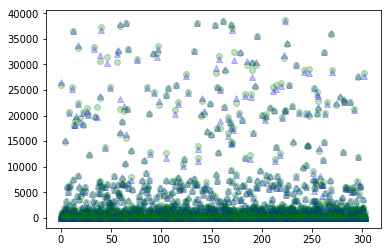

In [46]:
def c_kfold():
    '''
    Implementation of KFold cross-validation with k = 10
    '''
    k = 8
    kf = KFold(n_splits= k)
    lowestErr = sys.maxsize
    bestParameter = None
    # for i in np.arange(0.0001, 0.004, 0.0003):
    # for i in [0.0015, 0.002, 0.0025, 0.003]:
    i = 0.0008
    for j in [(140,140,140,140,140)]:
    # for i in [(35)]:
        print("Testing a new parameter: " + str(i) + ", " + str(j))
        cum_error = 0
        curr_k = 0
        for train, test in kf.split(c_xTr_fit):
            train_data = c_xTr_fit[train, :]
            train_ydata = c_yTr[train].ravel()
            train_ydata = train_ydata.astype(np.float)
            val_data = c_xTr_fit[test, :]
            val_ydata =  c_yTr[test].ravel()
            val_ydata = val_ydata.astype(np.float)
            
            model, mse = nn_train(train_data, val_data, train_ydata, val_ydata, i, j)
            print("MSE (k = " + str(curr_k) + "): " + str(mse))

            cum_error += mse
            curr_k += 1

        cum_error = cum_error / k
        if cum_error < lowestErr:
            lowestErr = cum_error
            bestParameter = i, j
        print("Total error: " + str(cum_error))

    print(lowestErr)
    print(bestParameter)
    return bestParameter

creative_model = c_kfold()

In [50]:
# temp cell to get NN accuracy on the whole train data

def make_nn(train_data, train_ydata, lri, hls):
    model = MLPRegressor(solver='lbfgs', hidden_layer_sizes = hls, verbose = True, learning_rate = 'adaptive', learning_rate_init = lri, batch_size = 400, max_iter = 1000, activation = 'relu', alpha = 0.6)
    model.fit(train_data, train_ydata)
    return model

c_submission_nn = make_nn(c_xTr_fit, c_yTr.ravel(), creative_model[0], creative_model[1])
# c_submission_nn
c_submission_nn = c_submission_nn.predict(c_xTe_fit)




<function matplotlib.pyplot.show(*args, **kw)>

0e+03, 2.21514446e+03, 2.17562591e+03, 2.57119846e+03,
        2.48822623e+03, 2.45086695e+03, 2.44935383e+03, 2.46371848e+03,
        2.37824031e+03, 2.47465783e+03, 2.54667270e+03, 2.49827664e+03,
        2.45885320e+03, 2.43807708e+03, 2.41164672e+03, 2.31498566e+03,
        2.32675938e+03, 2.34165916e+03, 2.32991942e+03, 2.28043068e+03,
        2.24052291e+03, 2.11969877e+03, 2.06045718e+03, 2.09495306e+03,
        2.01288575e+03, 1.98552702e+03, 1.97414824e+03, 1.95297438e+03,
        1.94955446e+03, 1.90834380e+03, 1.92246021e+03, 1.99857212e+03,
        1.97825947e+03, 1.96867026e+03, 1.94307420e+03, 1.94172662e+03,
        1.91707320e+03, 1.96020466e+03, 2.12392036e+03, 2.12812186e+03,
        2.16065258e+03, 2.18288520e+03, 2.19937946e+03, 2.19512861e+03,
        2.23231476e+03, 2.43291139e+03, 2.44862022e+03, 2.47643741e+03,
        2.49612206e+03, 2.50494900e+03, 2.53388737e+03, 2.61664779e+03,
        3.83249715e+02, 3.85245731e+02, 3.84176108e+02, 3.92504957e+02,
        3

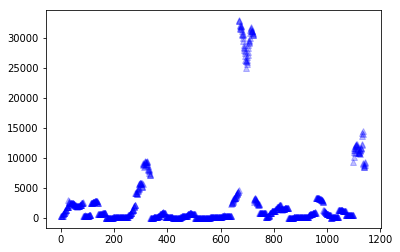

In [48]:
plt.plot(range(len(c_submission_nn)), c_submission_nn, 'b^', alpha = 0.25)
plt.show

c_submission_nn = [c_submission_nn]
# c_submission_nn

[Text(0.5,0,'Belgium'),
 Text(2.5,0,'Cyprus'),
 Text(4.5,0,'Denmark'),
 Text(6.5,0,'Iceland'),
 Text(8.5,0,'Italy'),
 Text(10.5,0,'Netherlands'),
 Text(12.5,0,'Portugal'),
 Text(14.5,0,'Spain'),
 Text(16.5,0,'Total Hospitalization'),
 Text(18.5,0,'15-24'),
 Text(20.5,0,'50-64'),
 Text(22.5,0,'Over 80'),
 Text(24.5,0,'t-2'),
 Text(26.5,0,'t-4'),
 Text(28.5,0,'t-6'),
 Text(30.5,0,'t-8'),
 Text(32.5,0,'t-10'),
 Text(34.5,0,'t-12'),
 Text(36.5,0,'t-14'),
 Text(38.5,0,'Next Week')]

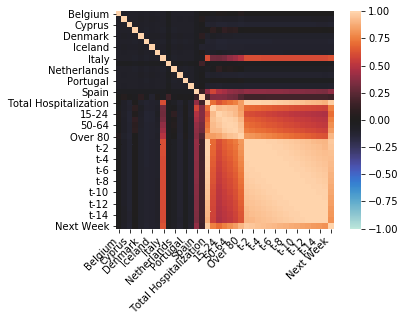

In [26]:
###############################################################################################
### Calculating the correlation matrix *before* removing date features Week and Day of Week ###
###############################################################################################

# data = np.concatenate((c_xTr_fit, c_yTr), axis = 1 )
# data = pd.DataFrame(data, columns = ['Belgium', 'Croatia', 'Cyprus', 'Czech', 'Denmark', 'Estonia', 'Iceland', 'Ireland', 'Italy', 'Lithuania', 'Netherlands', 'Norway', 'Portugal', 'Slovenia', 'Spain', 'DOW','Day', 'Week','Total Hospitalization', 'Under 15', '15-24', '25-49', '50-64','65-79', 'Over 80', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14', 't-15', 'Next Week'])
# data = data.astype(float)
# corr = data.corr(method = 'pearson')

# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     # cmap=sns.diverging_palette(240, 10, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

# plt.savefig('corrMat.png')

##############################################################################################
### Calculating the correlation matrix *after* removing date features Week and Day of Week ###
##############################################################################################

data = np.concatenate((c_xTr_fit, c_yTr), axis = 1 )
data = pd.DataFrame(data, columns = ['Belgium', 'Croatia', 'Cyprus', 'Czech', 'Denmark', 'Estonia', 'Iceland', 'Ireland', 'Italy', 'Lithuania', 'Netherlands', 'Norway', 'Portugal', 'Slovenia', 'Spain', 'Day', 'Total Hospitalization', 'Under 15', '15-24', '25-49', '50-64','65-79', 'Over 80', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14', 't-15', 'Next Week'])
data = data.astype(float)
corr = data.corr(method = 'pearson')

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    # cmap=sns.diverging_palette(240, 10, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('corrMat.png')



<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set? Did you reach the 150k MSE for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO columns. The first column should be named "country_id" and be a concatenation of the country and date in the first two columns of the test_no_label.csv. This is because for the Kaggle competition we need a unique identifier for every row. For instance, the first entry should be "Belgium 9/7/2020". The second column of the prediction csv should have the same name as the target metric (either "next_week_increase_decrease" or "next_week_hospitalizations") with your generated predictions. Your file should have 1144 total rows excluding the column names. The order should be the same as in the test_baseline/creative_no_label.csv. A sample predication file can be downloaded from Kaggle for each problem.

In [49]:
# TODO

# You may use pandas to generate a dataframe with country, date and your predictions first 
# and then use to_csv to generate a CSV file.


# Import the not yet fitted test data for name extraction"\
xTe_unfit = pd.read_csv('datasets/test_baseline_no_label.csv', sep= ',', encoding='unicode_escape').to_numpy()
xTe_unfit = np.append(xTe[:,:4],xTe[:,5:], axis = 1)

Te_name = xTe_unfit[:,0]
Te_date = xTe_unfit[:,1]

# Creating the first column of the submission csv
Te_col = []
for i in range(len(Te_name)):
    Te_col = np.append(Te_col, Te_name[i] + " " + Te_date[i])
Te_col = [Te_col]

yTr_flat = yTr.ravel()
yTr_flat = yTr_flat.astype('int')

##############################
### Part 1: Basic Solution ###
##############################

# # Train the SVM and use it to predict labels for the test data
# svm = make_svm(xTr_fit, yTr_flat, 5)
# Te_val1 = [svm.predict(xTe_fit)]

# # Te_val2 = [tr_test(xTe_fit, dec_tree(train, val, ytrain, yval))]
# # Te_val3 = [randomtr_test(xTe_fit, randomdec_tree(train, val, ytrain, yval))]

# # Export this array to the file "basic_submission.csv"
# final = np.append(Te_col, Te_val1, axis = 0).T
# np.savetxt("basic_submission.csv", final, delimiter = ',', fmt = ['%s', '%s'], header ='country_id,next_week_increase_decrease', comments='')
# print('Saved basic file')


#################################
### Part 2: Creative Solution ###
#################################

c_Te_val = c_submission_nn

c_final = np.append(Te_col, c_Te_val, axis = 0).T
np.savetxt("creative_submission.csv", c_final, delimiter= ',', fmt = ['%s', '%s'], header ='country_id,next_week_hospitalizations', comments = '')
print('Saved creative file')




Saved creative file


In [13]:
    c_Tr = pd.read_csv('datasets/train_creative.csv', sep= ',', encoding='unicode_escape')
    c_Tr_t = pd.read_csv('datasets/train_creative_t_values.csv', sep= ',', encoding='unicode_escape')
    dataset = c_Tr.append(c_Tr_t, sort=False)

<h2>Part 5: Resources and Literature Used</h2><p>